<a href="https://colab.research.google.com/github/yvesgit/UnpackAI/blob/main/Tabular_assignment_Yves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.3MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 194kB 19.1MB/s 
     |████████████████████████████████| 1.2MB 24.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 204.2MB 71kB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 204kB 57.9MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
#from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20


In [ ]:
pd.options.display.max_columns = 25

In [ ]:
mkdir ~/.kaggle

In [ ]:
cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
from kaggle import api

In [ ]:
path = URLs.path('rossmann')
path

Path('/root/.fastai/archive/rossmann')

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('rossmann-store-sales', path=path)
    file_extract(path/'rossmann-store-sales.zip')

path.ls(file_type='text')

100%|██████████| 6.99M/6.99M [00:00<00:00, 43.4MB/s]

(#4) [Path('train.csv'),Path('sample_submission.csv'),Path('store.csv'),Path('test.csv')]

In [ ]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [ ]:
stores = pd.read_csv(path/'store.csv', low_memory=False)

In [ ]:
df.tail()

,Store,DayOfWeek,Date,Sales,...,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,...,False,False,a,True
1017205,1112,2,2013-01-01,0,...,False,False,a,True
1017206,1113,2,2013-01-01,0,...,False,False,a,True
1017207,1114,2,2013-01-01,0,...,False,False,a,True
1017208,1115,2,2013-01-01,0,...,False,False,a,True


In [ ]:
df['Promo'].value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

In [ ]:
for col in ['Open','Promo',  'SchoolHoliday']:
  df[col] = df[col].astype('bool', copy=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   bool   
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 79.6+ KB


In [ ]:
stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
df['SchoolHoliday'].value_counts()

False    835488
True     181721
Name: SchoolHoliday, dtype: int64

In [ ]:
stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis =1, inplace=True)

In handling Nans, we see that the CompetitionOpen Since fields have a lot of Nans and intuitively do not seem the ost influential. So I dropped them.

In [ ]:
for col in ['Promo2SinceWeek', 'Promo2SinceYear']:
  stores[col]=stores[col].astype('Int64', copy=False, errors='ignore')

In [ ]:
stores['Promo2'] = stores['Promo2'].astype('bool', copy=False)

In [ ]:
stores['Promo2'].value_counts()

True     571
False    544
Name: Promo2, dtype: int64

Also, Competition distance seems important, and has a few Nans, but only 3, so let's drop those 3 rows - that is after merging the training and store datframes

In [ ]:
train = df.merge(stores, on='Store')
train.dropna(subset=['CompetitionDistance'], inplace=True)

In [ ]:
  train.head()

,Store,DayOfWeek,Date,Sales,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,...,False,<NA>,<NA>,NaN
1,1,4,2015-07-30,5020,...,False,<NA>,<NA>,NaN
2,1,3,2015-07-29,4782,...,False,<NA>,<NA>,NaN
3,1,2,2015-07-28,5011,...,False,<NA>,<NA>,NaN
4,1,1,2015-07-27,6102,...,False,<NA>,<NA>,NaN


In [ ]:
train.where(type(train) != pandas._libs.missing.NAType, np.nan)

KeyError: ignored

In [ ]:
train.loc[6000,'Promo2SinceWeek'] == 3

<NA>

Looking at Sales = 0, there seems no obvious other factor explaining this.Zero sales are well distributed among date, day of the week, Open, Promo, holidays, and store types.

We can see on the kaggle page that the vertical bar of zero sales breaks an otherwise well distributed looking Sales variable. So for the sake of the assignment I am dropping these, which account for over 17% of the data 

In [ ]:
train[train['Sales'] >1]['Date'].sort_values()

483619    2013-01-01
386137    2013-01-01
512659    2013-01-01
235513    2013-01-01
77677     2013-01-01
             ...    
310734    2015-07-31
620526    2015-07-31
909549    2015-07-31
313376    2015-07-31
0         2015-07-31
Name: Date, Length: 842152, dtype: object

In [ ]:
print(train.shape)
train = train.loc[train['Sales']>1]
print(train.shape)

(1014567, 16)
(842152, 16)


Let's add date parts as in the lesson

In [ ]:
train = add_datepart(train, 'Date')

In [ ]:
train.head(3)

,Store,DayOfWeek,Week,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,31,5263,555,True,True,0,True,c,a,1270.0,...,2015,7,31,4,212,True,False,False,False,False,False,1438300800
1,1,4,31,5020,546,True,True,0,True,c,a,1270.0,...,2015,7,30,3,211,False,False,False,False,False,False,1438214400
2,1,3,31,4782,523,True,True,0,True,c,a,1270.0,...,2015,7,29,2,210,False,False,False,False,False,False,1438128000


We now have 2 columns for day of week. Let's drop the new original one and keep the new one, in the hope that fast.ai works better with its own creations

In [ ]:
train.drop(['DayOfWeek'], inplace = True, axis =1)

In [ ]:
procs = [Categorify, FillMissing]

There is the same phenomenon going on here as in the lesson: the test set on Kaggle has all later dates than train set.

So let's do our split chronologically. First let's look at the range of dates

In [ ]:
train = train.sort_values(by=['Year', 'Month', 'Day']).reset_index()
train

,level_0,index,Store,Week,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,77677,85,1,4220,619,True,False,a,True,b,a,...,2013,1,1,1,1,False,True,False,True,False,True,1356998400
1,1,235513,259,1,6851,1444,True,False,a,True,b,b,...,2013,1,1,1,1,False,True,False,True,False,True,1356998400
2,2,238339,262,1,17267,2875,True,False,a,True,b,a,...,2013,1,1,1,1,False,True,False,True,False,True,1356998400
3,3,249459,274,1,3102,729,True,False,a,True,b,b,...,2013,1,1,1,1,False,True,False,True,False,True,1356998400
4,4,305081,335,1,2401,482,True,False,a,True,b,a,...,2013,1,1,1,1,False,True,False,True,False,True,1356998400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842147,842147,1012499,1111,31,5723,422,True,True,0,True,a,a,...,2015,7,31,4,212,True,False,False,False,False,False,1438300800
842148,842148,1013441,1112,31,9626,767,True,True,0,True,c,c,...,2015,7,31,4,212,True,False,False,False,False,False,1438300800
842149,842149,1014383,1113,31,7289,720,True,True,0,True,a,c,...,2015,7,31,4,212,True,False,False,False,False,False,1438300800
842150,842150,1015325,1114,31,27508,3745,True,True,0,True,a,c,...,2015,7,31,4,212,True,False,False,False,False,False,1438300800


In [ ]:
842152 * 0.75

631614.0

In [ ]:
#cond = (train.Sales<2011) | (df.saleMonth<10)
#train_idx = np.where( cond)[0]
#valid_idx = np.where(~cond)[0]

splits = (list(range(631614)),list(range(631614,842152 )) )

Before we split, let's look at cardinalities of categorical variable

In [ ]:
train.nunique().head(20)

level_0                842152
index                  842152
Store                    1112
Week                       52
Sales                   21732
Customers                4083
Open                        1
Promo                       2
StateHoliday                4
SchoolHoliday               2
StoreType                   4
Assortment                  3
CompetitionDistance       654
Promo2                      2
Promo2SinceWeek            24
Promo2SinceYear             7
PromoInterval               3
Year                        3
Month                      12
Day                        31
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842152 entries, 0 to 842151
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   level_0              842152 non-null  int64  
 1   index                842152 non-null  int64  
 2   Store                842152 non-null  int64  
 3   Week                 842152 non-null  UInt32 
 4   Sales                842152 non-null  int64  
 5   Customers            842152 non-null  int64  
 6   Open                 842152 non-null  bool   
 7   Promo                842152 non-null  bool   
 8   StateHoliday         842152 non-null  object 
 9   SchoolHoliday        842152 non-null  bool   
 10  StoreType            842152 non-null  object 
 11  Assortment           842152 non-null  object 
 12  CompetitionDistance  842152 non-null  float64
 13  Promo2               842152 non-null  bool   
 14  Promo2SinceWeek      420424 non-null  Int64  
 15  Promo2SinceYear  

We have more distinct values for Store than for CompetitionDistance. so we will cut off at 600 and move Store from cont to cat. But first we have to cast 'UInt32' to 'int64' because adddatepart gave of Week in that format, and cont_ct_split cannot interpret it

In [ ]:
train['Week'] = train['Week'].astype('int64')

In [ ]:
for col in ['Promo2SinceWeek', 'Promo2SinceYear']:
  train[col]=stores[col].astype('float64', copy=False, errors='ignore')

  #also have to cast this one back, too bad

In [ ]:
dep_var = 'Sales'
cont,cat = cont_cat_split(train, max_card=600, dep_var=dep_var)

In [ ]:
cat.append('Store')
cont.remove('Store')

In [ ]:
to = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(631614, 210538)

In [ ]:
save_pickle(path/'to.pkl',to)

Create a Random Forest, as in the lesson

In [ ]:
# Function to create random forests

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
#Define loss function:

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = rf(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(516.694889, 730.340392)

Compare with Out of Bag error

In [ ]:
r_mse(m.oob_prediction_, y)

587.33835

Much lower than validation loss !

Now let's look at Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[0:15]

,cols,imp
26,Customers,0.702803
2,Promo,0.077902
27,CompetitionDistance,0.051491
5,StoreType,0.042218
25,index,0.029161
21,Store,0.024056
12,Dayofweek,0.018580
6,Assortment,0.017667
8,PromoInterval,0.008367
13,Dayofyear,0.006970


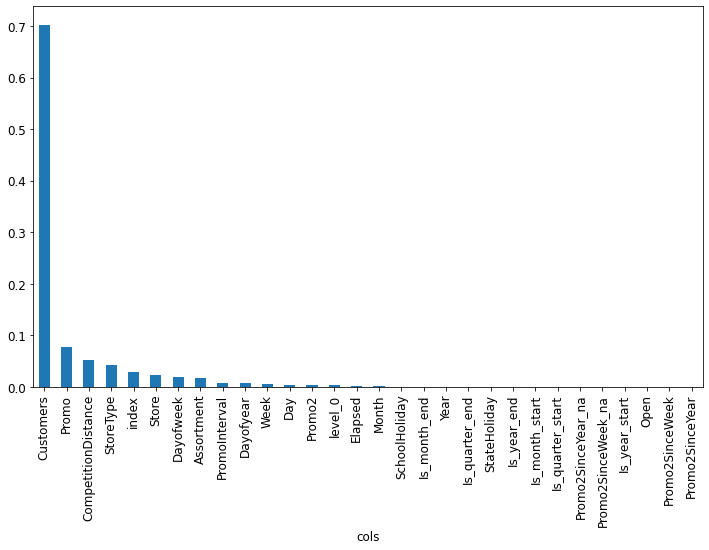

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'bar', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Problem! Data Leakage

Customers is suspisiously important and explanatory of Sales.
Thinking about it, these must be highly correlated:
If you have few customers you will have few sales, and if you have many customers, you will probably have more Sales
A look at to Sales and Customers columns on the Kaggle page shows that they are close to proportional.

We should therefore take customers out of the independent variables and redo the steps

In [ ]:
xs_trimmed = xs.drop('Customers', axis =1)
valid_xs_trimmed = valid_xs.drop('Customers', axis =1)

In [ ]:
m_trim = rf(xs_trimmed, y);

In [ ]:
m_rmse(m_trim, xs_trimmed, y), m_rmse(m_trim, valid_xs_trimmed, valid_y)

(1045.536053, 1421.335061)

In [ ]:
r_mse(m_trim.oob_prediction_, y)

1165.809712

In [ ]:
fi_trim = rf_feat_importance(m_trim, xs_trimmed)
fi_trim[0:15]

,cols,imp
26,CompetitionDistance,0.223940
25,index,0.185655
21,Store,0.159510
2,Promo,0.153131
12,Dayofweek,0.064441
5,StoreType,0.042632
6,Assortment,0.029455
8,PromoInterval,0.024428
13,Dayofyear,0.024260
24,level_0,0.020906


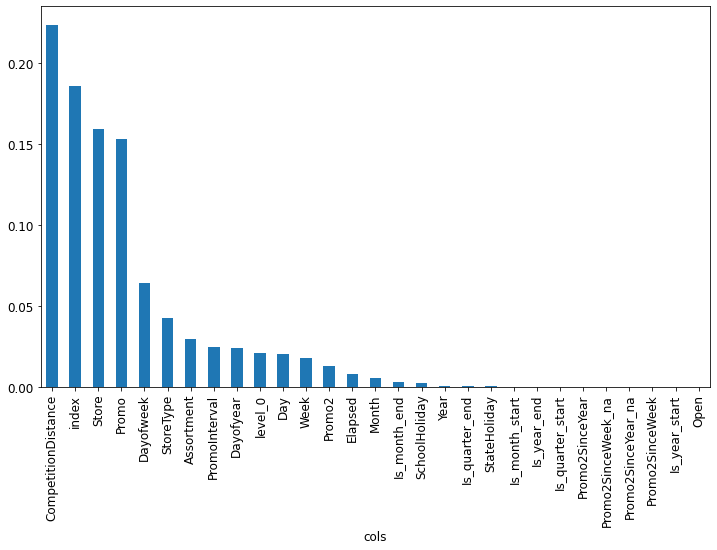

In [ ]:
plot_fi(fi_trim[:30]);

That's more like it!